# Decision Tree part

# data loading and splitting

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load and clean data
df = pd.read_csv("heart.csv")
df.columns = df.columns.str.strip()

# Identify categorical and numerical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if (df[col].dtype in ['int64', 'float64']) 
          and (col != "HeartDisease")]

# Split data into features (X) and target (Y)
X = df.drop("HeartDisease", axis=1)
Y = df["HeartDisease"]

# Split into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.30, stratify=Y, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

# Reset indices to ensure alignment between features and labels
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Initialize encoders/scalers
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
scaler = StandardScaler()

# Process training data
x_train_cat = ohe.fit_transform(x_train[cat_col])
x_train_num = scaler.fit_transform(x_train[num_col])
x_train_processed = np.hstack([x_train_num, x_train_cat])

# Process validation/test data
x_val_cat = ohe.transform(x_val[cat_col])
x_val_num = scaler.transform(x_val[num_col])
x_val_processed = np.hstack([x_val_num, x_val_cat])

x_test_cat = ohe.transform(x_test[cat_col])
x_test_num = scaler.transform(x_test[num_col])
x_test_processed = np.hstack([x_test_num, x_test_cat])

# Get feature names
num_feature_names = num_col
cat_feature_names = ohe.get_feature_names_out(cat_col)
all_feature_names = num_feature_names + list(cat_feature_names)

# Create DataFrames with reset indices
x_train = pd.DataFrame(x_train_processed, columns=all_feature_names)
x_val = pd.DataFrame(x_val_processed, columns=all_feature_names)
x_test = pd.DataFrame(x_test_processed, columns=all_feature_names)

print(f"Training Set: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

Training Set: (642, 20), Validation: (92, 20), Test: (184, 20)


# different depths to try with 

In [99]:

#min depth of a full binary tree log2(918)=10 , the best depth is around this value
valid_depths=[4,5,6,7,8,9,10,11,12,13,14,15,16]
trained_trees={}   # map from depth to training node


# Node class

In [100]:
import math
import random

class TrainingNode:
    def __init__(self, x_train, y_train, current_depth=0, label=None):
        self.x_train = x_train
        self.y_train = y_train
        self.current_depth = current_depth
        self.label = label
        self.split_feature = None
        self.split_value = None  # Threshold for binary splits (0.5 for one-hot encoded features)
        self.children = {}       # Only 'left' and 'right'

    def compute_entropy(self, y):
        if len(y) == 0:
            return 0
        proportions = y.value_counts(normalize=True)
        return -sum(p * math.log2(p) for p in proportions if p > 0)

    def majority_label(self):
        if len(self.y_train) == 0:
            return self.label
        return self.y_train.mode()[0]

    def best_split(self):
        base_entropy = self.compute_entropy(self.y_train)
        best_gain = 0
        best_feature = None
        best_value = None
        
        for feature in self.x_train.columns:
            values = self.x_train[feature]
            
            if pd.api.types.is_numeric_dtype(values):
                sorted_vals = sorted(values.unique())
                # For one-hot encoded features, sorted_vals will be [0, 1], threshold = 0.5
                for i in range(len(sorted_vals) - 1):
                    threshold = (sorted_vals[i] + sorted_vals[i+1]) / 2
                    left_mask = values <= threshold
                    right_mask = values > threshold

                    # Calculate entropy for left and right
                    left_entropy = self.compute_entropy(self.y_train[left_mask])
                    right_entropy = self.compute_entropy(self.y_train[right_mask])

                    weighted_entropy = (
                        left_mask.sum() * left_entropy
                        + right_mask.sum() * right_entropy
                    ) / len(self.y_train)

                    gain = base_entropy - weighted_entropy
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_value = threshold
        
        return best_feature, best_value, best_gain

    def expand_node(self, max_depth, parent_label=None):
        # 1) If node has no samples, set label to parent's majority
        if self.x_train.shape[0] == 0:
            self.label = parent_label
            return
        
        # 2) Stop if max depth reached or node is pure
        if self.current_depth >= max_depth or self.compute_entropy(self.y_train) == 0:
            self.label = self.majority_label()
            return
        
        # 3) Find best split 
        best_feature, best_value, gain = self.best_split()

        if best_feature is None:
            best_feature = random.choice(list(self.x_train.columns))
            values = self.x_train[best_feature]
            if pd.api.types.is_numeric_dtype(values):
                min_val = values.min()
                max_val = values.max()
                best_value = random.uniform(min_val, max_val)
            else:
                best_value = 0.5
        
        self.split_feature = best_feature
        self.split_value = best_value

        # Create left and right children
        left_mask = self.x_train[best_feature] <= best_value
        right_mask = ~left_mask

        # Left Child
        left_x = self.x_train[left_mask]
        left_y = self.y_train[left_mask]
        self.children['left'] = TrainingNode(left_x, left_y, self.current_depth + 1)
        self.children['left'].expand_node(max_depth, parent_label=self.majority_label())

        # Right Child
        right_x = self.x_train[right_mask]
        right_y = self.y_train[right_mask]
        self.children['right'] = TrainingNode(right_x, right_y, self.current_depth + 1)
        self.children['right'].expand_node(max_depth, parent_label=self.majority_label())

    def predict_one(self, x):
        if self.split_feature is None or len(self.children) == 0:
            return self.label
        
        # Always binary split (left/right)
        if x[self.split_feature] <= self.split_value:
            return self.children['left'].predict_one(x)
        else:
            return self.children['right'].predict_one(x)

    def predict(self, X):
        return [self.predict_one(row) for _, row in X.iterrows()]

# training at different levels

In [101]:
# train at different levels

for depth in valid_depths:
    root = TrainingNode(x_train, y_train, current_depth=0)
    root.expand_node(max_depth=depth)
    trained_trees[depth] = root

# choosing best depth

In [102]:
# evaluation using validation set (determine best depth without overfitting)
from sklearn.metrics import accuracy_score
def evaluate_tree(tree, x_val, y_val):
    predictions = tree.predict(x_val)
    return accuracy_score(y_val, predictions)


best_val_score = 0.0

for depth, tree in trained_trees.items():
    val_score = evaluate_tree(tree, x_val, y_val)
    print(f"Depth={depth}, Validation Accuracy={val_score:.4f}")
    
    if val_score >= best_val_score:
        best_val_score = val_score
        best_depth = depth
        best_tree = tree

print(f"\nBest Depth: {best_depth} with Validation Accuracy: {best_val_score:.4f}")

Depth=4, Validation Accuracy=0.8696
Depth=5, Validation Accuracy=0.8804
Depth=6, Validation Accuracy=0.8370
Depth=7, Validation Accuracy=0.8152
Depth=8, Validation Accuracy=0.7935
Depth=9, Validation Accuracy=0.8043
Depth=10, Validation Accuracy=0.8152
Depth=11, Validation Accuracy=0.8261
Depth=12, Validation Accuracy=0.8152
Depth=13, Validation Accuracy=0.8152
Depth=14, Validation Accuracy=0.8152
Depth=15, Validation Accuracy=0.8152
Depth=16, Validation Accuracy=0.8152

Best Depth: 5 with Validation Accuracy: 0.8804


# Results and Evaluation

Test Accuracy: 0.8315
Test F1 Score: 0.8426


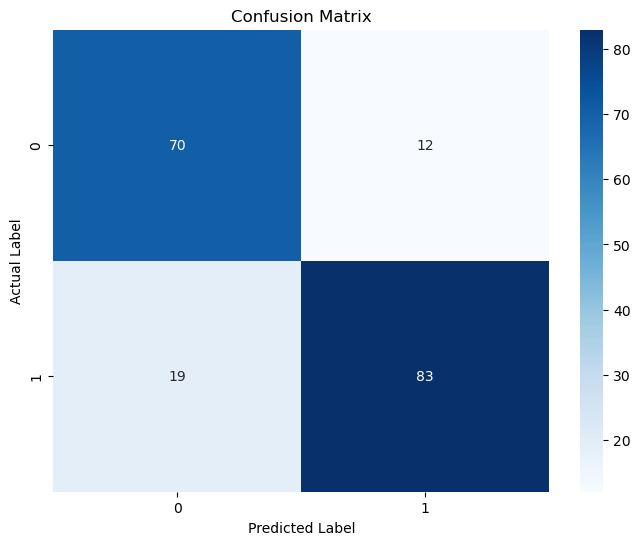

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Assuming best_tree is the trained optimal tree, and x_test, y_test are your test data and labels:
test_predictions = best_tree.predict(x_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)

# Output the accuracy and F1 score
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix as a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()
